# Ensemble

## Import Libraries
First of all, let's import all the libraries we will need later.

In [ ]:
from google.colab import drive
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
from sklearn import metrics

## Load Dataset from Google Drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/My Drive/Baldi_Cioffo/SplittedDataset.zip" -d "/content"

## Set Parameters

In [ ]:
DATASET_PATH = "/content/SplittedDataset"
VALIDATION_PATH = DATASET_PATH + '/validation_set'
TEST_PATH = DATASET_PATH + '/test_set'

LOCAL_MODELS_FOLDER = "/content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/drive/My Drive/Baldi_Cioffo/models"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

# Default values to load the dataset
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

## Utility Functions

In [ ]:
def set_seed ():
  ''' 
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  seed = 24
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(seed)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(seed)
  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(seed)

def load_validation_set (image_height, image_width, batch_size):
  '''
  load_validation_set loads the validation set from the "validation_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the validation set
  '''
  return image_dataset_from_directory(
    VALIDATION_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = False,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def load_test_set (image_height, image_width, batch_size):
  '''
  load_test_set loads the test set from the "test_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the test set
  '''
  return image_dataset_from_directory(
    TEST_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = False,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def evaluate_model(y_score, y_pred):
  '''
  evaluate_model is used to plot some statistics about the performance on the test set
  :param model: model to consider
  '''
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

## Load Dataset

In [ ]:
set_seed()

Since the sizes of the images used for the CNN from scratch and the pre-trained networks are different, we load two different versions of the validation and test sets.

In [ ]:
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 2132 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


In [ ]:
scratch_validation_dataset = load_validation_set(300, 300, BATCH_SIZE)
scratch_test_dataset = load_test_set(300, 300, BATCH_SIZE)

Found 2132 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


## Load models
With the purpose of creating an ensemble model, we load the best performing models.

In [ ]:
vgg_model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/vgg16/eperiment12_cut_ft_3_blocks.h5')

In [ ]:
resnet_model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/resnet-50/Experiment10_remove_blocks_fine_tuning.h5')

In [ ]:
from_scratch = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/from_scratch/OneDense256_2dropout.h5')

In [ ]:
resnet_model_2 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/resnet-50/Experiment11_remove_blocks_fine_tuning.h5')

### Scores on Test Set

In [ ]:
# vgg_model
vgg_test_scores = vgg_model.predict(test_dataset)
# resnet_model
resnet_test_scores = resnet_model.predict(test_dataset)
# from_scratch
from_scratch_test_scores = from_scratch.predict(scratch_test_dataset)
# resnet_model_2
resnet_2_test_scores = resnet_model_2.predict(test_dataset)

In [ ]:
TRUE_TEST_LABELS = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)

In [ ]:
MODEL_TEST_SCORES = [vgg_test_scores, resnet_test_scores, from_scratch_test_scores, resnet_2_test_scores]

### Scores on Validation Set

In [ ]:
# vgg_model
vgg_validation_scores = vgg_model.predict(validation_dataset)
# resnet_model
resnet_validation_scores = resnet_model.predict(validation_dataset)
# from_scratch
from_scratch_validation_scores = from_scratch.predict(scratch_validation_dataset)
# resnet_model_2
resnet_2_validation_scores = resnet_model_2.predict(validation_dataset)

In [ ]:
TRUE_VALIDATION_LABELS = tf.concat([labels_batch for data_batch, labels_batch in validation_dataset], axis = 0)

In [ ]:
MODEL_VALIDATION_SCORES = [vgg_validation_scores, resnet_validation_scores, from_scratch_validation_scores, resnet_2_validation_scores]

## Average Model
The easiest way to pool the predictions of a set of classifiers is to average their predictions at inference time. Having four different models, this results in 

```
ensemble_prediction = 0.25 * (prediction_a + prediction_b + prediction_c + prediction_d)
```

In [ ]:
ensemble_scores = []
n_models = len(MODEL_TEST_SCORES)
for i in range(len(TRUE_TEST_LABELS)):
  ensemble_scores.append(np.sum([1/n_models*model_score[i] for model_score in MODEL_TEST_SCORES]))

ensemble_predictions = np.rint(ensemble_scores)

Classification report: 
              precision    recall  f1-score   support

           0     0.9567    0.8894    0.9218       696
           1     0.9482    0.9805    0.9641      1437

    accuracy                         0.9508      2133
   macro avg     0.9525    0.9349    0.9429      2133
weighted avg     0.9510    0.9508    0.9503      2133



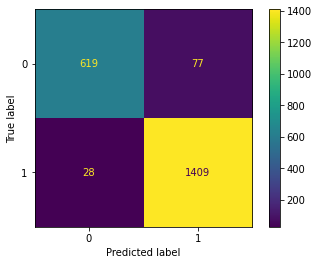

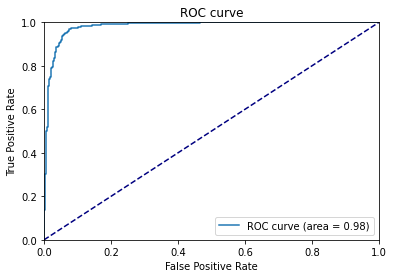

In [ ]:
evaluate_model(ensemble_scores, ensemble_predictions)

## Weighted Average Model
All classifiers are more or less equally good but, in order to make the most of the ensemble technique, it is smarter to take a weighted average of the predictions so that the best classifiers have higher weights than the worst classifiers. 

The following function will allow us to calculate the weighted average of the predictions of the classifiers. 

In [ ]:
def weighted_average_scores(models_scores, weights):
  if len(weights) != len(models_scores):
    return
  weighted_scores = []
  for i in range(len(models_scores[0])):
    weighted_score = [weight*model_score[i] for weight,model_score in zip(weights, models_scores)]
    weighted_average = np.sum(weighted_score, axis = 0)
    weighted_scores.append(weighted_average)
  return weighted_scores

## Learning the best weights through a Genetic Algorithm
In general, a good set of ensembling weights should be learned from the validation data. There are many possible techniques, but we decided to implement a Genetic Algorithm that can find an optimal solution to the problem. 

Since the validation set is unbalanced, the optimization of the weights will be performed by considering the weighted F-measure and not the accuracy. The following function allows us to obtain this metric for a set of weights. 

In [ ]:
def get_f1_measure(weights):
  weighted_scores = weighted_average_scores(MODEL_VALIDATION_SCORES, weights)
  predictions = np.rint(weighted_scores)
  return metrics.f1_score(TRUE_VALIDATION_LABELS, predictions, average="weighted")

### Genetic Algorithm
We defined the problem of finding the best set of weights as follows.
* Each chromosome is composed of four genes (real encoding) that represent the
weights associated with the four models that make up the ensemble.
* The initial population of candidate solutions is randomly generated, ensuring that the sum of the different genes for each chromosome is equal to 1 (constraint imposed by being weights).
* As fitness function, the weighted F-measure on the validation set is used. The goal is then to maximize this function.
*   The parameters of the genetic algorithm, namely population size, number of generations, and crossover and mutation probabilities are chosen experimentally. 




In [ ]:
# tournament selection
def selection(population, scores, k=5):
  selection_indexes = [rn.randrange(0, len(population), 1) for i in range(k)]
  selected_index = selection_indexes[0]
  for i in selection_indexes[1:]:
    # perform the tournament, i.e. check if new selection is better than last one
    if scores[i] > scores[selected_index]:
      selected_index = i
  return population[selected_index]

In [ ]:
# average crossover
def crossover(parent_1, parent_2, r_genes):
  children_1, children_2 = parent_1.copy(), parent_2.copy()
  random_genes_indexes = [rn.randrange(0, len(parent_1), 1) for i in range(r_genes)]
  for i in random_genes_indexes:
    average = (parent_1[i] + parent_2[i])/2
    children_1[i] = average
    children_2[i] = average
  return [[float(i)/sum(children_1) for i in children_1], 
          [float(i)/sum(children_2) for i in children_2]] # normalization is needed because the sum of weights must be one

In [ ]:
# all-positions mutation
def mutation(chromosome):
  index = rn.randint(0, len(chromosome)-1)
  chromosome[index] = rn.random()
  return [float(i)/sum(chromosome) for i in chromosome]

In [ ]:
# weighted f1-measure on validation set
def fitness(chromosome):
  return get_f1_measure(chromosome)

In [ ]:
def genetic_algorithm(fitness, number_of_models, population_size, number_of_generations, p_crossover, p_mutation):
  # initial population of random chromosomes
  population = []
  for i in range(population_size):
    chromosome = [rn.random() for _ in range(number_of_models)]
    chromosome = [float(i)/sum(chromosome) for i in chromosome]
    population.insert(i, chromosome)
  # keep track of best solution
  best_chromosome, best_fitness = 0, fitness(population[0])
  # enumerate generations
  for generation in range(number_of_generations):
    # evaluate all candidates in the population
    scores = [fitness(chromosome) for chromosome in population]
    # check for new best solution
    new_best = False
    for i in range(population_size):
      if scores[i] > best_fitness:
        new_best = True
        best_chromosome, best_fitness = population[i], scores[i]
    if new_best:
      print(">Generation %d, new best f(%s) = %.4f" % (generation+1,  best_chromosome, best_fitness))
    # select parents
    selected = [selection(population, scores) for _ in range(population_size)]
    # create the next generation
    children = []
    for i in range(0, population_size, 2):
      # get selected parents in pairs
      p1, p2 = selected[i], selected[i+1]
      # crossover and mutation
      if rn.random() < p_crossover:
        for c in crossover(p1, p2, r_genes=2):
          if rn.random() < p_mutation:
            # mutation
            mutation(c)
          # store for next generation
          children.append(c)
      else:
        children.append(p1)
        children.append(p2)
    # replace population
    population = children
  return [best_chromosome, best_fitness]

In [ ]:
weights = None
fmeasure = -10
for i in range(10):
  print("Iteration ", i)
  cw, cfm = genetic_algorithm(fitness, 4, 100, 100, 0.4, 0.005)
  if cfm > fmeasure:
    fmeasure = cfm
    weights = cw
  print("------------")

Iteration  0
>Generation 1, new best f([0.263480639094814, 0.22221303752331642, 0.15928040816940814, 0.35502591521246146]) = 0.9462
>Generation 2, new best f([0.3196496105258499, 0.20252669323839914, 0.15425031177863283, 0.32357338445711814]) = 0.9472
>Generation 4, new best f([0.3853892925618668, 0.02341571811571648, 0.13979764560174257, 0.45139734372067414]) = 0.9477
>Generation 6, new best f([0.36179720093492695, 0.024031982448189763, 0.1508934151788453, 0.463277401438038]) = 0.9482
>Generation 7, new best f([0.3645005258805319, 0.024211547844153716, 0.14454894649226388, 0.46673897978305046]) = 0.9487
------------
Iteration  1
>Generation 1, new best f([0.17826443342197676, 0.08900115558707504, 0.2563026862058052, 0.47643172478514306]) = 0.9468
>Generation 2, new best f([0.35697810969080374, 0.031021685621809163, 0.14578029282129926, 0.4662199118660879]) = 0.9487
------------
Iteration  2
>Generation 1, new best f([0.16441895864318076, 0.11455541558069993, 0.2244050612146944, 0.4966

In [ ]:
print(weights)
print(fmeasure)

[0.36857568310278194, 0.0069563149916040306, 0.15587371527649352, 0.447800069311696]
0.9491523390316557


Classification report: 
              precision    recall  f1-score   support

           0     0.9478    0.9138    0.9305       696
           1     0.9590    0.9756    0.9672      1437

    accuracy                         0.9555      2133
   macro avg     0.9534    0.9447    0.9489      2133
weighted avg     0.9553    0.9555    0.9552      2133



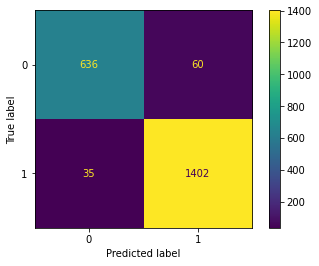

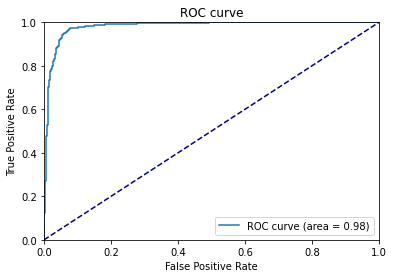

In [ ]:
ensemble_scores = weighted_average_scores(MODEL_TEST_SCORES, weights)
ensemble_predictions = np.rint(ensemble_scores)
evaluate_model(ensemble_scores, ensemble_predictions)